In [30]:
from time import time_ns

import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [4]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [5]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [6]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [7]:
def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return  "".join(generated_tokens)

token = generate(inputs, max_tokens=10)
print(token)

 fence and ran to the other side of the fence


## multiple

In [8]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id


In [9]:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [10]:
# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [11]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [12]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)


attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [13]:
# position_ids tell the transform the ordinal position of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference, we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
print("position_ids:", position_ids)
position_ids.masked_fill_(attention_mask == 0, 1)

position_ids: tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [-1, -1,  0,  1,  2,  3,  4],
        [-1, -1, -1,  0,  1,  2,  3]])


tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [14]:
# save as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [15]:
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=-1)
next_token_ids

tensor([13990,   319,   307])

In [16]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

In [17]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [18]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape(-1, 1),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.ones((next_token_ids.shape[0], 1))],
                dim=1
            ),
            "past_key_values": past_key_values
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)

    return ["".join(tokens) for tokens in generated_tokens]


In [19]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [20]:
for prompt, generated, in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



In [23]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(10)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompt, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs=1
duration: 0.3043630123138428
throughput: 32.855503446287806 tokens/s
avg latency: 0.03043630123138428

bs=2
duration: 0.2544410228729248
throughput: 78.60367708861388 tokens/s
avg latency: 0.02544410228729248

bs=4
duration: 0.2321031093597412
throughput: 172.33720009327064 tokens/s
avg latency: 0.023210310935974122

bs=8
duration: 0.2372438907623291
throughput: 337.20573264474064 tokens/s
avg latency: 0.02372438907623291

bs=16
duration: 0.26306724548339844
throughput: 608.2095082038529 tokens/s
avg latency: 0.026306724548339842

bs=32
duration: 0.3864140510559082
throughput: 828.1272358641558 tokens/s
avg latency: 0.03864140510559082

bs=64
duration: 0.5345520973205566
throughput: 1197.2640332121064 tokens/s
avg latency: 0.05345520973205566

bs=128
duration: 0.7802138328552246
throughput: 1640.5758858642475 tokens/s
avg latency: 0.07802138328552247

bs=256
duration: 1.739175796508789
throughput: 1471.9616068363696 tokens/s
avg latency: 0.1739175796508789

bs=512
duration: 3.0126

In [31]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

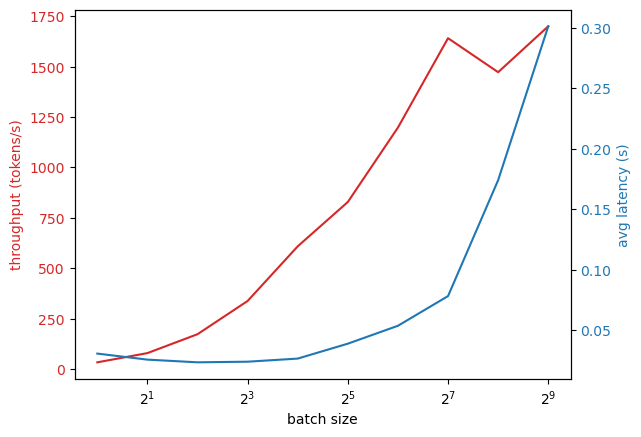

In [32]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)